# Flax-Pilot VAE MNIST Notebook

This notebook demonstrates the usage of flax-pilot to train a VAE. The workflow uses distributed training using jax.pmap on Kaggle GPU

**Use TensorFlow-cpu instead of TensorFlow to avoid any issues between TensorFlow & Jax.**

In [1]:
!pip install -q tensorflow-cpu

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.
tensorflow 2.15.0 requires ml-dtypes~=0.2.0, but you have ml-dtypes 0.3.2 which is incompatible.
tensorflow 2.15.0 requires tensorboard<2.16,>=2.15, but you have tensorboard 2.16.2 which is incompatible.


In [2]:
!pip install -q mergedeep

In [3]:
import jax
import optax
import tensorflow as tf
import flax.linen as nn
import jax.numpy as jnp
import jax.random as jr

In [4]:
import jax, flax, orbax.checkpoint
jax.__version__, flax.__version__, orbax.checkpoint.__version__

('0.4.26', '0.8.4', '0.5.15')

### Create a simple VAE Model.

*Note: The main model must always have a '**deterministic**' param to handle layers like dropout. Not adding '**deterministic**' param will lead to error as flax-pilot always expects this param, irrespective of whether the model has any stochastic layers or not.*

In [5]:
class Encoder(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.relu(nn.Conv(features=32, kernel_size=(3, 3), strides=2, padding='SAME')(x))
        x = nn.relu(nn.Conv(features=64, kernel_size=(3, 3), strides=2, padding='SAME')(x))
        x = x.reshape(x.shape[0], -1)
        x = nn.relu(nn.Dense(16)(x))
        mean = nn.Dense(2)(x)
        logvar = nn.Dense(2)(x)
        return mean, logvar

    
class Decoder(nn.Module):    
    @nn.compact
    def __call__(self, z):
        y = nn.relu(nn.Dense(49*64)(z))
        y = y.reshape(y.shape[0], 7, 7, 64)
        y = nn.relu(nn.ConvTranspose(features=64, kernel_size=(3, 3), strides=2, padding='SAME')(y))
        y = nn.relu(nn.ConvTranspose(features=32, kernel_size=(3, 3), strides=2, padding='SAME')(y))
        y = nn.ConvTranspose(features=1, kernel_size=(3, 3), padding='SAME')(y)
        y = nn.sigmoid(y)
        return y
        
        
class VAE(nn.Module):
    def setup(self,):
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    
    # Must have 'deterministic param'.
    @nn.compact
    def __call__(self, x, deterministic):
        mean, logvar = self.encode(x)
        z = self.reparam_trick(mean, logvar)
        y = self.decode(z)
        return (mean, logvar), y
        
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)
    
    def reparam_trick(self, mean, logvar):
        e = jr.normal(self.make_rng('normal'), mean.shape)
        return mean + jnp.exp(0.5*logvar)*e


### Create tf.data.Dataset
Distributed training in this notebook is performed using jax.pmap. jax.pmap expects the first dimension of its input tensor as the number of devices in parallel.<br>
<br> 
So Input tensor must have shape **(NO_OF_DEVICES, LOCAL_BATCH_SIZE, ...)**<br>
MNIST Images have shape : **(28, 28, 1)**<br>
In this case, input shape will be : **(2, 128, 28, 28, 1)**. So, we have 2 devices, each device will receive a batch of shape **(128, 28, 28, 1)**.

GLOBAL_BATCH_SIZE = LOCAL_BATCH_SIZE * NO_OF_DEVICES<br>
In this case, GLOBAL_BATCH_SIZE = 256

In [6]:
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(256).batch(128, True)
train_ds = train_ds.map(lambda x, y: (tf.expand_dims(x, -1)/255), num_parallel_calls=tf.data.AUTOTUNE)

# Second batching for distributing with pmap.
train_ds = train_ds.batch(2, True)
train_ds = train_ds.repeat().as_numpy_iterator()

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.shuffle(256).batch(128, True)
val_ds = val_ds.map(lambda x, y: (tf.expand_dims(x, -1)/255), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(2, True)
val_ds = val_ds.repeat().as_numpy_iterator()

train_ds, val_ds

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


(NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x7dc01be12710>),
 NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x7dc019c34be0>))

### Loss Function

#### Inputs to the loss function

##### The `loss_fn` will always receive these six specific inputs, described as follows:

1. **params**:
   - **Description**: The model's parameters.
   - **Obtained by**: Using the `init` method of `flax.linen.Module`.
   - **Example**: `params = model.init(prng_key, input_shape)`.



2. **apply**:
   - **Description**: The `apply` method from `flax.linen.Module`, used to call other methods within the module.



3. **sample**:
   - **Description**: The input data to the model.


4. **deterministic**:
   - **Description**: Indicates whether to enable deterministic behavior in layers (similar to the `training` parameter in Keras).
   - **Usage**: 
     - Set to `True` during validation (`val_step`), where dropout is disabled.
     - Set to `False` during training (`train_step`).



5. **global_key**:
   - **Description**: A PRNGKey used to seed random variables, important for dropout and other random operations within the model.
   - **Management**: 
     - Updated using `jax.fold_in` within the `train_step` and `val_step` functions to ensure a unique key for each step.
     - When flax model requires multliple keys in its forward pass, the global prng key received here can be splitted into multliple prng keys using `jax.random.split`. These splits can be represented as a dict where keys of the dict are the `rng_name` used from within the model using `self.make_rng(rng_name)` and value as the prng key itself.
     - From within the model, prng keys can be accessed by `self.make_rng(rng_name)`.
     
     
    
6. **step**:
   - **Description**: Represents the current iteration or step number of the optimizer during training.
   - **Usage**: Can be used to weigh losses based on the current number of iterations. For example, it allows implementing techniques like annealing the KL divergence weight in a variational autoencoder or any other time-dependent adjustments during training.
   - **Management**:
     - Passed directly to the `loss_fn` within the `train_step` and `val_step` functions.
     - It is incremented at each iteration of the training loop.
     - Enables dynamic adjustments of the loss function or other training parameters as training progresses, offering more fine-grained control over the training process.


### Note:
- All these six parameters are crucial for training and must not be removed or replaced.
- Their names can be changed, but their order and functionality must remain the same.



This structure ensures that the `loss_fn` receives all necessary inputs in a consistent manner, facilitating proper model training and evaluation.

#### Outputs from the loss function

The function must return two elements:

1. **Scalar loss**:
   - **Description**: The value which should be minimized.
   - **Details**: This scalar is minimized with respect to the first parameter of the function, `params`.



2. **loss_metric_values_dict**:
   - **Description**: A dictionary that must always contain two keys, **'mt'** (metric tracker) and **'lt'** (loss tracker).
   - **Structure**:
     - Each of these parent keys must hold a child dictionary as its value, representing different metric and loss trackers.
     - The child dictionary's key names can be any string but must match with the tracker instances dictionary (explained in later cells).
     - The child dictionary's values must be the values being tracked.
   - **Details**:
     - For losses, the loss tracker is used to track the losses, so the child dictionaries of **'lt'** must have scalar loss as their values.
     - For classification metrics like Accuracy or F1Score, the child dictionary of **'mt'** will expect a tuple of `(y_true, y_pred)` as its value or a dictionary like `{'true': true, 'pred': pred}` as its value.
     - These values of child dict are passed to the `update` function of tracker instances. Check out `trackers.py` to understand the expected inputs of each tracker's update function.

In [53]:
def loss_fn(params, apply, sample, deterministic, global_key, step):
    x = sample
    (mean, logvar), y = apply(params, x, deterministic=deterministic, rngs={'normal': global_key})
    
    recons_loss = -(x*jnp.log(y+0.00001) + (1-x)*jnp.log(1-y+0.00001)).sum(axis=(1, 2)).mean()
    kl_loss = (-0.5 * (1 + logvar - jnp.square(mean) - jnp.exp(logvar))).sum(axis=(1, )).mean()
    loss = recons_loss + kl_loss
    loss_metric_values_dict = { 
        'lt': {'kl_loss': kl_loss.mean(), 'recons_loss': recons_loss.mean()},
        'mt': dict()
        }
    return loss, loss_metric_values_dict


### Access to the modules

In [33]:
import os
os.listdir("/kaggle/input/fpilot")

['trackers', 'checkpoints', 'training']

In [32]:
import glob, sys
sys.path.append("/kaggle/input")

### Creating tracker functions

Trackers are represented in a dictionary, with keys **'mt'** (metric tracker) and **'lt'** (loss tracker) being mandatory. Each of these keys must have a child dictionary as its value. The child dictionary's key names must match the child key names in `loss_metric_values_dict`. The value of the child dictionaries must be tracker instances.


In [10]:
import fpilot.trackers.basic_trackers as tr

trackers = {
        'lt': {'kl_loss': tr.Mean(), 'recons_loss': tr.Mean()},
        'mt':{}
}

### Trainer

The `Trainer` instance takes in five parameters:

1. **flax_model**:
   - **Description**: A `flax.linen.Module` instance.



2. **input_shape**:
   - **Description**: Shapes of input tensors passed to the model.
   - **Type**: A dictionary where the key is the parameter name of the model's `__call__` method and the value is the shape of the tensor.



3. **optimizer**:
   - **Description**: 
     - In single-objective training: It must be a single Optax optimizer. This optimizer is applied uniformly to all model parameters to minimize the loss function.
     - In multi-objective training (e.g., GANs): It must be a dictionary of optimizers. The keys of this dictionary correspond to the parameter's key  in the Flax `TrainState.params` that need to be optimized, and the values are the respective Optax optimizers for those parameters. This allows different sets of parameters to be optimized with different strategies.



4. **loss_metric_fn**:
   - **Description**: The loss function as explained above.



5. **trackers**:
   - **Description**: A dictionary of trackers as explained in the previous cell.

In [59]:
from fpilot.training.trainer import Trainer

trainer = Trainer(VAE(), {'x': (1, 28, 28, 1)}, optax.adam(0.001), loss_fn2, trackers)

Check the docstring of **Trainer.train** for explaination 

In [55]:
trainer.train(30, train_ds, val_ds, 60000//256, 10000//256, '/kaggle/working/pilot-examples/vae_v2', 3)

Epoch 1: 100%|██████████| 234/234 [00:03<00:00, 59.55it/s] 


Train:  kl_loss: 4.6061406, recons_loss: 231.78123, time: 3.932544469833374
Val:  kl_loss: 5.4383945, recons_loss: 193.66977, time: 1.0076565742492676
State saved..


Epoch 2: 100%|██████████| 234/234 [00:01<00:00, 169.17it/s]


Train:  kl_loss: 5.084843, recons_loss: 184.60736, time: 1.3854222297668457
Val:  kl_loss: 5.761605, recons_loss: 177.91019, time: 0.07101821899414062
State saved..


Epoch 3: 100%|██████████| 234/234 [00:01<00:00, 168.98it/s]


Train:  kl_loss: 5.3170094, recons_loss: 173.34857, time: 1.3879318237304688
Val:  kl_loss: 5.5675535, recons_loss: 170.4552, time: 0.07147026062011719
State saved..


Epoch 4: 100%|██████████| 234/234 [00:01<00:00, 168.77it/s]


Train:  kl_loss: 5.2837095, recons_loss: 168.57858, time: 1.3892760276794434
Val:  kl_loss: 5.5001764, recons_loss: 166.96225, time: 0.07587289810180664
State saved..


Epoch 5: 100%|██████████| 234/234 [00:01<00:00, 168.37it/s]


Train:  kl_loss: 5.3384533, recons_loss: 165.42728, time: 1.392488956451416
Val:  kl_loss: 5.741378, recons_loss: 164.26361, time: 0.07457184791564941
State saved..


Epoch 6: 100%|██████████| 234/234 [00:01<00:00, 168.02it/s]


Train:  kl_loss: 5.471902, recons_loss: 162.77516, time: 1.395714282989502
Val:  kl_loss: 5.728514, recons_loss: 161.74567, time: 0.07120966911315918
State saved..


Epoch 7: 100%|██████████| 234/234 [00:01<00:00, 167.66it/s]


Train:  kl_loss: 5.5818644, recons_loss: 160.44083, time: 1.3985140323638916
Val:  kl_loss: 5.9426565, recons_loss: 159.74408, time: 0.07322144508361816
State saved..


Epoch 8: 100%|██████████| 234/234 [00:01<00:00, 167.12it/s]


Train:  kl_loss: 5.6804314, recons_loss: 158.56146, time: 1.4033405780792236
Val:  kl_loss: 6.0219026, recons_loss: 158.18338, time: 0.07195591926574707
State saved..


Epoch 9: 100%|██████████| 234/234 [00:01<00:00, 167.11it/s]


Train:  kl_loss: 5.7774954, recons_loss: 157.07477, time: 1.403132438659668
Val:  kl_loss: 6.120907, recons_loss: 156.99812, time: 0.07538843154907227
State saved..


Epoch 10: 100%|██████████| 234/234 [00:01<00:00, 166.91it/s]


Train:  kl_loss: 5.843608, recons_loss: 155.92622, time: 1.4050796031951904
Val:  kl_loss: 6.0998907, recons_loss: 155.78062, time: 0.06926202774047852
State saved..


Epoch 11: 100%|██████████| 234/234 [00:01<00:00, 166.52it/s]


Train:  kl_loss: 5.8940363, recons_loss: 155.03511, time: 1.4078481197357178
Val:  kl_loss: 6.154539, recons_loss: 155.53297, time: 0.09550666809082031
State saved..


Epoch 12: 100%|██████████| 234/234 [00:01<00:00, 166.08it/s]


Train:  kl_loss: 5.934238, recons_loss: 154.22852, time: 1.4116883277893066
Val:  kl_loss: 6.246154, recons_loss: 154.65863, time: 0.06821107864379883
State saved..


Epoch 13: 100%|██████████| 234/234 [00:01<00:00, 165.86it/s]


Train:  kl_loss: 5.9670315, recons_loss: 153.722, time: 1.4142124652862549
Val:  kl_loss: 6.212187, recons_loss: 154.14735, time: 0.07054615020751953
State saved..


Epoch 14: 100%|██████████| 234/234 [00:01<00:00, 165.46it/s]


Train:  kl_loss: 5.9934473, recons_loss: 153.13544, time: 1.4171643257141113
Val:  kl_loss: 6.237133, recons_loss: 154.13675, time: 0.06787300109863281
State saved..


Epoch 15: 100%|██████████| 234/234 [00:01<00:00, 165.29it/s]


Train:  kl_loss: 6.005868, recons_loss: 152.93164, time: 1.4186666011810303
Val:  kl_loss: 6.2199616, recons_loss: 153.27301, time: 0.07015395164489746
State saved..


Epoch 16: 100%|██████████| 234/234 [00:01<00:00, 164.81it/s]


Train:  kl_loss: 6.0238333, recons_loss: 152.48022, time: 1.4228384494781494
Val:  kl_loss: 6.3200064, recons_loss: 152.76181, time: 0.08963561058044434
State saved..


Epoch 17: 100%|██████████| 234/234 [00:01<00:00, 164.91it/s]


Train:  kl_loss: 6.0416923, recons_loss: 151.9851, time: 1.4219272136688232
Val:  kl_loss: 6.3140936, recons_loss: 152.10077, time: 0.07662415504455566
State saved..


Epoch 18: 100%|██████████| 234/234 [00:01<00:00, 164.77it/s]


Train:  kl_loss: 6.075672, recons_loss: 151.59286, time: 1.4230144023895264
Val:  kl_loss: 6.173554, recons_loss: 152.11166, time: 0.07595300674438477
State saved..


Epoch 19: 100%|██████████| 234/234 [00:01<00:00, 164.29it/s]


Train:  kl_loss: 6.0826597, recons_loss: 151.31949, time: 1.4274170398712158
Val:  kl_loss: 6.2400475, recons_loss: 151.57251, time: 0.06823444366455078
State saved..


Epoch 20: 100%|██████████| 234/234 [00:01<00:00, 164.33it/s]


Train:  kl_loss: 6.1215353, recons_loss: 150.93272, time: 1.4267492294311523
Val:  kl_loss: 6.2683353, recons_loss: 151.56216, time: 0.07493376731872559
State saved..


Epoch 21: 100%|██████████| 234/234 [00:01<00:00, 164.51it/s]


Train:  kl_loss: 6.122447, recons_loss: 150.54514, time: 1.427065372467041
Val:  kl_loss: 6.2518425, recons_loss: 151.0955, time: 0.07303810119628906
State saved..


Epoch 22: 100%|██████████| 234/234 [00:01<00:00, 164.65it/s]


Train:  kl_loss: 6.140222, recons_loss: 150.24664, time: 1.4242591857910156
Val:  kl_loss: 6.257863, recons_loss: 150.97845, time: 0.07524323463439941
State saved..


Epoch 23: 100%|██████████| 234/234 [00:01<00:00, 164.64it/s]


Train:  kl_loss: 6.147483, recons_loss: 149.90742, time: 1.424464225769043
Val:  kl_loss: 6.2913337, recons_loss: 150.88152, time: 0.07324862480163574
State saved..


Epoch 24: 100%|██████████| 234/234 [00:01<00:00, 165.12it/s]


Train:  kl_loss: 6.1582527, recons_loss: 149.66348, time: 1.4200611114501953
Val:  kl_loss: 6.3497305, recons_loss: 150.72374, time: 0.0722959041595459
State saved..


Epoch 25: 100%|██████████| 234/234 [00:01<00:00, 165.28it/s]


Train:  kl_loss: 6.202548, recons_loss: 149.4497, time: 1.4188275337219238
Val:  kl_loss: 6.327853, recons_loss: 150.682, time: 0.0739755630493164
State saved..


Epoch 26: 100%|██████████| 234/234 [00:01<00:00, 165.86it/s]


Train:  kl_loss: 6.1972075, recons_loss: 149.21362, time: 1.414027452468872
Val:  kl_loss: 6.4334536, recons_loss: 150.2718, time: 0.07491111755371094
State saved..


Epoch 27: 100%|██████████| 234/234 [00:01<00:00, 165.85it/s]


Train:  kl_loss: 6.234352, recons_loss: 148.9277, time: 1.413656234741211
Val:  kl_loss: 6.361809, recons_loss: 149.99329, time: 0.07259631156921387
State saved..


Epoch 28: 100%|██████████| 234/234 [00:01<00:00, 166.61it/s]


Train:  kl_loss: 6.2284684, recons_loss: 148.67264, time: 1.4078559875488281
Val:  kl_loss: 6.355484, recons_loss: 150.04614, time: 0.07466864585876465
State saved..


Epoch 29: 100%|██████████| 234/234 [00:01<00:00, 166.51it/s]


Train:  kl_loss: 6.2404995, recons_loss: 148.41272, time: 1.4090197086334229
Val:  kl_loss: 6.3031583, recons_loss: 149.85928, time: 0.07299375534057617
State saved..


Epoch 30: 100%|██████████| 234/234 [00:01<00:00, 166.58it/s]


Train:  kl_loss: 6.255579, recons_loss: 148.26085, time: 1.4080801010131836
Val:  kl_loss: 6.3037167, recons_loss: 149.64423, time: 0.07251095771789551
State saved..


### Access any method of the model

To access methods of the model, one can call the Trainer instance. **Check docstring to understand its working.**
<br>The params are explained below

1. **rngs**:
   - **Description**: A dictionary where the values are `jax.random.PRNGKey` instances and the keys are the names used inside the model to reference these PRNGKeys.



2. **tensor_inputs**:
   - **Description**: The tensor inputs passed to the model's method you plan to call.
   - **Type**: A dictionary where each key is the name of a method parameter and each value is the corresponding tensor input.
   - **Note**: Tensor inputs must include a device dimension due to `jax.pmap` decoration, e.g., `(NO_OF_DEVICES, LOCAL_BATCH_SIZE, ...)`.



3. **method**:
   - **Description**: A string representing the method of the model you plan to call.
   - **Default**: The default value is the `__call__` method.



4. **kwargs**:
   - **Description**: Used to pass any static arguments to the method, such as the `deterministic` parameter.



Below are some examples.

*Note: Tensor inputs to methods are jax.pmap decorated so, inputs must include device dimension. For ex. __(NO_OF_DEVICES, LOCAL_BATCH_SIZE, ...)__*

#### Model call
The callable Trainer function accepts param '**method**' which represents the which method of the model to call. Default value is the **call** method.

In [21]:
sample = next(val_ds)[:, :8]

rngs = {'normal': jax.random.PRNGKey(53)}
tensor_inputs = {'x': sample}

output = trainer(rngs, tensor_inputs, deterministic=False)[1]

#### Model.decode

In [61]:
rand = jr.normal(jr.PRNGKey(13), (2, 8, 2))

rngs = {'normal': jax.random.PRNGKey(13)}
tensor_inputs = {'x': rand}

output = trainer(rngs, tensor_inputs, method='decode')

### Evaluate the model

In [23]:
trainer.evaluate(val_ds, 10000//256)

Val:  kl_loss: 5.8912625, recons_loss: 159.81491, time: 0.07672953605651855


### Compute trackers

In [24]:
trainer.compute_trackers()

{'lt': {'kl_loss': Array([6.3865633, 6.3977027], dtype=float32),
  'recons_loss': Array([148.05116, 148.03146], dtype=float32)},
 'mt': {}}

### Save & Load checkpoints

In [58]:
# args: location to save checkpoint
trainer.save_state('/kaggle/working/pilot-examples/vae_v2_samplesave')

State saved..


In [60]:
# args: path to saved checkpoint folder, step number of checkpoint to restore
trainer.load_state('/kaggle/working/pilot-examples/vae_v2_samplesave', 7020)

### Visualize results

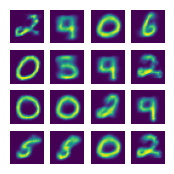

In [62]:
import matplotlib.pyplot as plt
plot_images = iter(output.reshape(16, 28, 28, 1))
fig, ax = plt.subplots(4, 4, figsize=(2, 2))

for x in range(4):
    for y in range(4):
        ax[x, y].imshow(next(plot_images))
        ax[x, y].axis('off')